## Clustering

### R Packages

In [1]:
#  Module: Clustering Case Study 
#  Version 1.1
#  Topic : Clustering
#  Example source: https://www.kaggle.com/wendykan/lending-club-loan-data
#####################################################################
#  For support or questions, contact Sri Krishnamurthy at
#  sri@quantuniversity.com
#  Copyright 2016 QuantUniversity LLC.
#####################################################################

### R packages
## Data wrangling
# install.packages("dplry")
library(dplyr)

## Clustering
# install.packages("cluster")
library(cluster) # for gower similarity and pam

## Visualization 
# install.packages("Rtsne")
# install.packages("ggplot2")
library(Rtsne) # for t-SNE plot with dimension reduction 
library(ggplot2) # for visualization


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



### Step 1 Reading data

In [2]:
### Step 1 Reading data
LendingClubLoan <- read.csv("LendingClubLoan.csv")
LendingClubLoan_Clustering <- dplyr::select(LendingClubLoan, -loan_status_Binary)

# Randomly select 5000 rows
set.seed(33)
LendingClubLoan_Clustering <- LendingClubLoan_Clustering[sample(1:nrow(LendingClubLoan_Clustering),
                                                                5000, replace=FALSE), ]
str(LendingClubLoan_Clustering)

'data.frame':	5000 obs. of  16 variables:
 $ loan_amnt          : int  4425 25000 7000 20000 12000 3000 30000 7200 5600 10000 ...
 $ term               : Factor w/ 2 levels " 36 months"," 60 months": 1 2 1 2 2 1 2 1 1 1 ...
 $ int_rate           : num  8.9 18.25 13.49 11.99 9.99 ...
 $ installment        : num  141 638 238 445 255 ...
 $ grade              : Factor w/ 7 levels "A","B","C","D",..: 1 4 3 2 2 3 3 1 3 2 ...
 $ sub_grade          : Factor w/ 35 levels "A1","A2","A3",..: 5 20 11 10 6 11 12 1 13 9 ...
 $ emp_length         : Factor w/ 12 levels "< 1 year","1 year",..: 1 9 11 6 3 4 3 3 2 4 ...
 $ home_ownership     : Factor w/ 3 levels "MORTGAGE","OWN",..: 3 1 3 3 1 3 3 1 1 3 ...
 $ annual_inc         : num  60000 156000 60000 56000 71000 ...
 $ verification_status: Factor w/ 3 levels "Not Verified",..: 2 2 1 3 3 1 3 1 1 2 ...
 $ issue_d            : Factor w/ 5 levels "11-Aug","11-Dec",..: 4 3 4 1 5 4 3 3 2 2 ...
 $ purpose            : Factor w/ 13 levels "car","credit_card"

### Step 2 Calculating distance

In [3]:
### Step 2 Calculating distance
gower_dist <- daisy(LendingClubLoan_Clustering, metric = "gower")

## Step 2-1 Checking attributes to ensure the correct methods are being used
# (I = interval, N = nominal)
summary(gower_dist)

12497500 dissimilarities, summarized :
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0059007 0.4306900 0.4982600 0.4944800 0.5623500 0.8589400 
Metric :  mixed ;  Types = I, N, I, I, N, N, N, N, I, N, N, N, N, I, I, I 
Number of objects : 5000

#### Step 2-2 Outputting most similar pair

In [4]:
## Step 2-2 Outputting most similar pair
gower_mat <- as.matrix(gower_dist)

LendingClubLoan_Clustering[
  which(gower_mat == min(gower_mat[gower_mat != min(gower_mat)]),
        arr.ind = TRUE)[1, ], ]

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths
4299,3600,36 months,7.9,112.65,A,A4,10+ years,MORTGAGE,90000,Not Verified,11-Oct,other,NY,16.28,0,0
6067,3000,36 months,7.9,93.88,A,A4,10+ years,MORTGAGE,87000,Not Verified,11-Oct,other,NY,18.03,0,0


#### Step 2-3 Outputting most dissimilar pair

In [5]:
## Step 2-3 Outputting most dissimilar pair
LendingClubLoan_Clustering[
  which(gower_mat == max(gower_mat[gower_mat != max(gower_mat)]),
        arr.ind = TRUE)[1, ], ]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths
6091,35000,35000,34875,60 months,22.35,973.64,F,F5,1 year,MORTGAGE,340000,Source Verified,11-Oct,Current,credit_card,IL,3.6,4,0
3719,2500,2500,2500,36 months,6.62,76.76,A,A2,n/a,RENT,61200,Verified,11-Nov,Fully Paid,other,AZ,26.12,0,1


### Step 3 Selecting number of clusters 

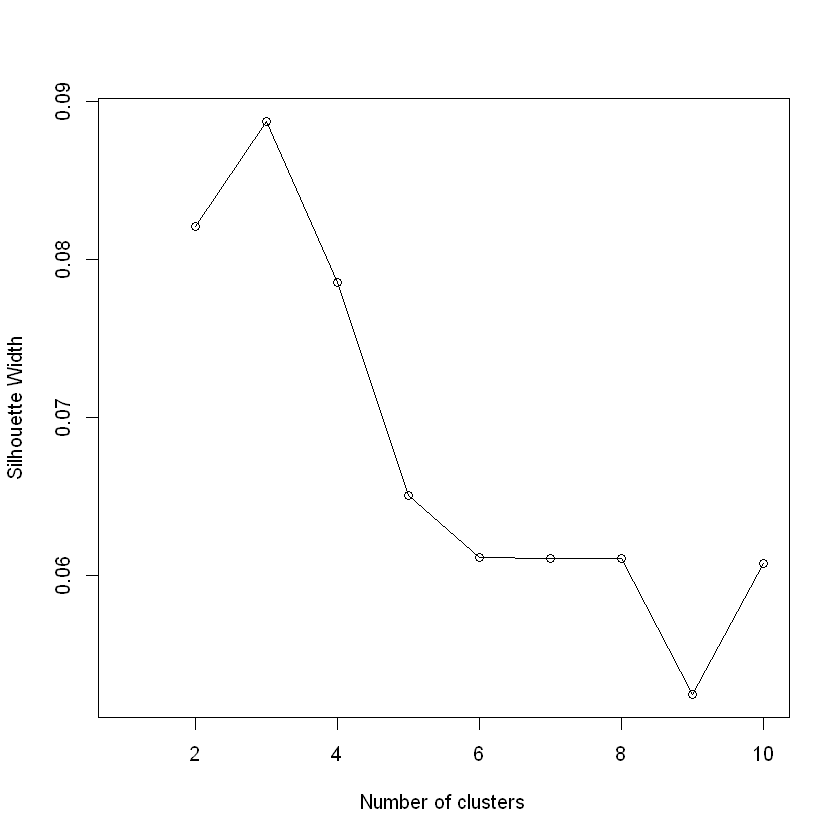

In [5]:
### Step 3 Selecting number of clusters 
sil_width <- c(NA)

for(i in 2:10){
  pam_fit <- pam(gower_dist,
                 diss = TRUE,
                 k = i)
  
  sil_width[i] <- pam_fit$silinfo$avg.width
}

# Plot sihouette width (higher is better, based on the result, 3  clusters yeil the highest value)
plot(1:10, sil_width,
     xlab = "Number of clusters",
     ylab = "Silhouette Width")
lines(1:10, sil_width)

### Step 4 Partitioning around medoids (PAM) 

#### Step 4-1 Summary of clustering ruselts

In [4]:
### Step 4 Partitioning around medoids (PAM) 
## Step 4-1 Summary of clustering results
pam_fit <- pam(gower_dist, diss = TRUE, k = 3)

pam_results <- LendingClubLoan_Clustering %>%
  mutate(cluster = pam_fit$clustering) %>%
  group_by(cluster) %>%
  do(the_summary = summary(.))

pam_results$the_summary

[[1]]
   loan_amnt             term         int_rate      installment      grade   
 Min.   : 1000    36 months:1388   Min.   : 5.42   Min.   :  30.16   A:1050  
 1st Qu.: 5500    60 months: 111   1st Qu.: 6.62   1st Qu.: 172.48   B: 193  
 Median : 9500                     Median : 7.90   Median : 281.62   C:  90  
 Mean   :10610                     Mean   : 9.33   Mean   : 329.59   D: 110  
 3rd Qu.:14000                     3rd Qu.:10.65   3rd Qu.: 424.73   E:  45  
 Max.   :35000                     Max.   :23.91   Max.   :1283.50   F:   9  
                                                                     G:   2  
   sub_grade       emp_length   home_ownership   annual_inc    
 A4     :284   10+ years:450   MORTGAGE:964    Min.   : 10080  
 A1     :262   < 1 year :151   OWN     :125    1st Qu.: 43154  
 A2     :193   2 years  :136   RENT    :410    Median : 60000  
 A5     :170   5 years  :128                   Mean   : 71548  
 A3     :141   3 years  :121                   3rd

#### Step 4-2 Center medoid of each cluster

In [10]:
## Step 4-2 Exemplars of each cluster
LendingClubLoan_Clustering[pam_fit$medoids, ]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths
6289,7200,7200,6950,36 months,7.9,225.29,A,A4,10+ years,RENT,37200,Source Verified,11-Oct,Fully Paid,debt_consolidation,FL,15.55,0,0
6000,19075,19075,19075,60 months,13.49,438.82,C,C1,10+ years,MORTGAGE,82776,Verified,11-Oct,Fully Paid,debt_consolidation,CA,14.08,0,1
24,10000,10000,10000,36 months,11.71,330.76,B,B3,5 years,RENT,50000,Not Verified,11-Dec,Fully Paid,debt_consolidation,CA,16.01,0,0


#### Step 4-3 Visualization with reduced-dimension 

In [ ]:
## Step 4-3 Visualization with reduced-dimension 
tsne_obj <- Rtsne(gower_dist, is_distance = TRUE)

tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(pam_fit$clustering))

ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster)) +
  ggtitle("Clusters on reduced-dimension")

#### Step 4-4 Plotting clusters over two variables

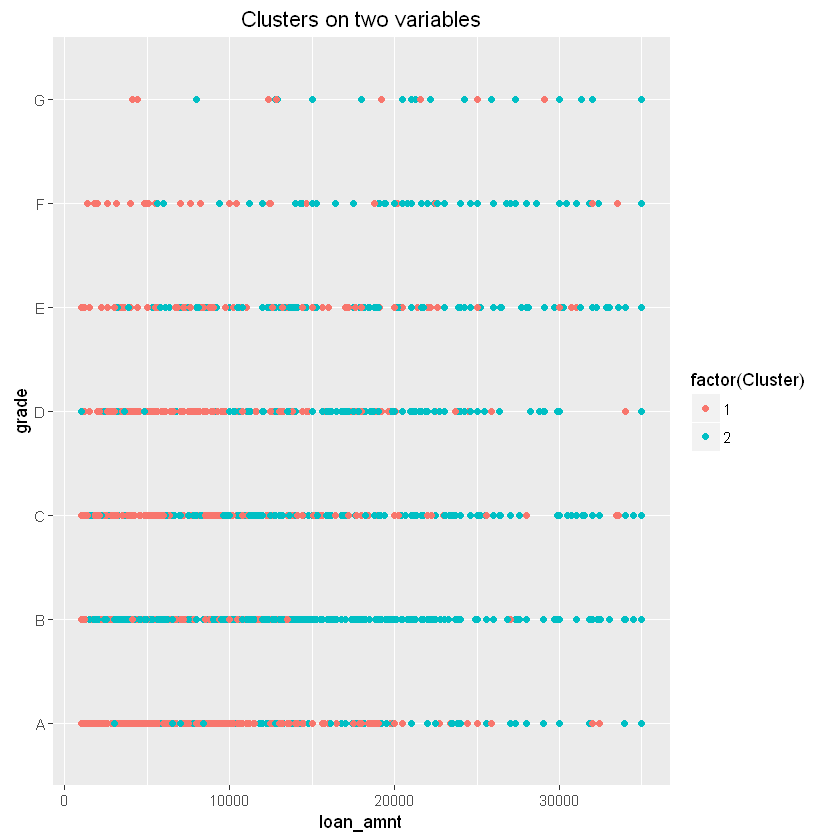

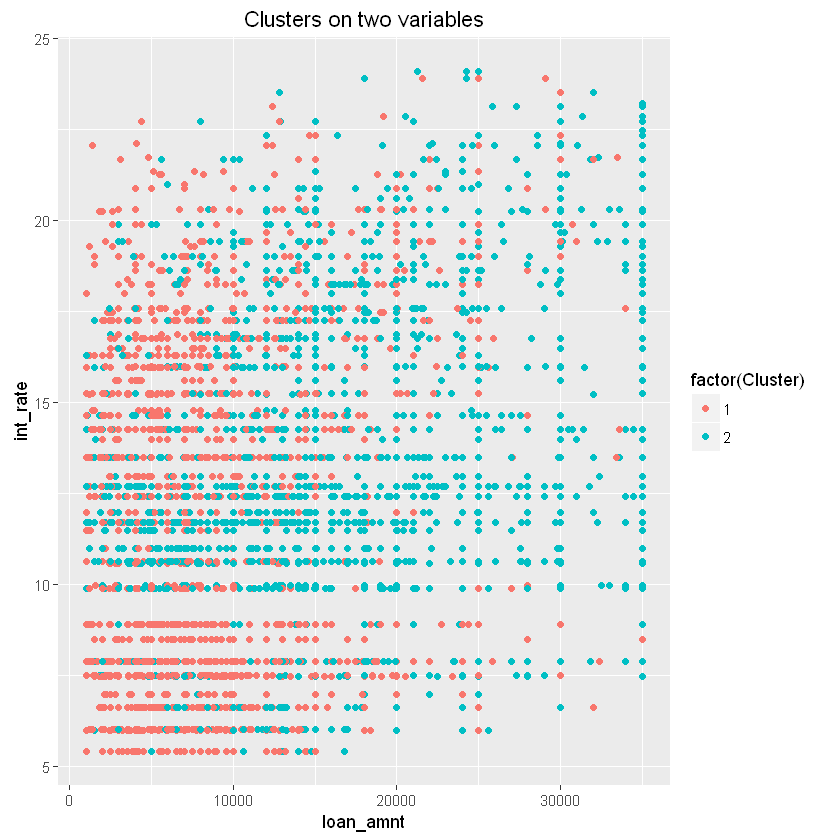

In [8]:
## Step 4-4 Plotting clusters over two variables
Clustering <- LendingClubLoan_Clustering %>%
  mutate(Cluster = pam_fit$clustering)

ggplot(aes(x = loan_amnt, y = grade), data = Clustering) +
  geom_point(aes(color = factor(Cluster))) +
  ggtitle("Clusters on two variables")

ggplot(aes(x = loan_amnt, y = int_rate), data = Clustering) + 
  geom_point(aes(color = factor(Cluster))) +
  ggtitle("Clusters on two variables")

### Step 5 Agglomerative hierarchical clustering

#### Step 5-1 Computes agglomerative hierarchical clustering

In [ ]:
### Step 5 Agglomerative hierarchical clustering
## Step 5-1 Computes agglomerative hierarchical clustering
agn <- agnes(gower_dist, metric = "manhattan", stand = FALSE)

plot(agn1, main= "Hierarchical clustering")

#### Step 5-2 Visualization on reduced-dimension 

In [ ]:
## Step 5-2 Visualization on reduced-dimension 
HierarchicalCluster <- LendingClubLoan_Clustering %>%
  mutate(Cluster=cutree(agn1,2))

tsne_obj <- Rtsne(gower_dist, is_distance = TRUE)

tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(cutree(agn1,2)))

ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster)) +
  ggtitle("Clusters on reduced-dimension Plot")

#### Step 5-3 Visualization on two variables

In [ ]:
## Step 5-3 Visualization on two variables
ggplot(aes(x = loan_amnt, y = grade), data = HierarchicalCluster) +
  geom_point(aes(color = factor(Cluster))) +
  ggtitle("Clusters on two variables")

ggplot(aes(x = loan_amnt, y = int_rate), data = HierarchicalCluster) + 
  geom_point(aes(color = factor(Cluster))) +
  ggtitle("Clusters on two variables")